## DavisSML Tensorflow Lab 1

Some content is taken from 
- www.tensorflow.org 
- http://rail.eecs.berkeley.edu/deeprlcourse/

To install tensorflow use pip:
`pip install tensorflow`

There are 2 exercises below. Do not use Keras or another high level API.

### Tensors

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

- Tensorflow is based around tensor objects
- Tensors can be symbolic or actual data
- Eager execution actually creates the tensors, not just symbolically.  Without it the Tensors would only be symbolic until a session is started.

In [2]:
tf.enable_eager_execution()

Several types of special tensors are
- tf.Variable : typically parameters in your model
- tf.constant : fixed values (gradients will not be calculated wrt them)
- tf.placeholder : a tensor waiting to be assigned a value; not compatible with eager execution
- tf.SparseTensor : a sparse tensor

In [3]:
# initialize these constants
a = tf.constant(1.0)
b = tf.constant(2.0)

# mathematical operations are defined on tensors
c = a + b

print(c)

tf.Tensor(3.0, shape=(), dtype=float32)


Above are scalars which are order 0 tensors, other types are below:

In [4]:
mammal = tf.Variable("Elephant", tf.string) # order 0
ignition = tf.Variable(451, tf.int16)
floating = tf.Variable(3.14159265359, tf.float64)
its_complicated = tf.Variable(12.3 - 4.85j, tf.complex64)

In [5]:
mammal.get_shape()

TensorShape([])

Here are some order 1 tensors of various types:

In [6]:
mystr = tf.Variable(["Hello","World"], tf.string) #order 1
cool_numbers  = tf.Variable([3.14159, 2.71828], tf.float32)
first_primes = tf.Variable([2, 3, 5, 7, 11], tf.int32)
its_very_complicated = tf.Variable([12.3 - 4.85j, 7.5 - 6.23j], tf.complex64)

The shape of the tensor is like that of numpy arrays, they will tell you the order and dimensions.

In [7]:
its_complicated.get_shape(), its_very_complicated.get_shape(),first_primes.get_shape()

(TensorShape([]), TensorShape([Dimension(2)]), TensorShape([Dimension(5)]))

In [8]:
beta_init = np.random.uniform(0,1,(32,32,32))
betas = [tf.convert_to_tensor(beta_init[0,0,0], dtype=tf.float32),
         tf.convert_to_tensor(beta_init[:,0,0], dtype=tf.float32),
         tf.convert_to_tensor(beta_init[:,:,0], dtype=tf.float32), #order 2
         tf.convert_to_tensor(beta_init, dtype=tf.float32)]

[beta.get_shape() for beta in betas]

[TensorShape([]),
 TensorShape([Dimension(32)]),
 TensorShape([Dimension(32), Dimension(32)]),
 TensorShape([Dimension(32), Dimension(32), Dimension(32)])]

Tensor operations input and output tensors, and will cast to a tensor if needed.

In [9]:
print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))

tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


Even when in eager mode Tensors are different than arrays because
- they are immutable : the data cannot be modified without reassiging the variable
- they can live on GPUs as comfortably as CPUs

Why are they immutable?

You can assign slices to other variables:

In [10]:
X = tf.Variable([[1,2,3],[3,4,5]])
Y = X[:2,:2]

In [11]:
Y

<tf.Tensor: id=96, shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>

In [12]:
X.assign([[2,2,3],[3,4,5]])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[2, 2, 3],
       [3, 4, 5]])>

In [13]:
X, Y

(<tf.Variable 'Variable:0' shape=(2, 3) dtype=int32, numpy=
 array([[2, 2, 3],
        [3, 4, 5]])>, <tf.Tensor: id=96, shape=(2, 2), dtype=int32, numpy=
 array([[1, 2],
        [3, 4]])>)

In [14]:
beta = tf.convert_to_tensor(beta_init, dtype=tf.float32)
beta.device

'/job:localhost/replica:0/task:0/device:CPU:0'

Can use GPU if it is available, because many operations are then parallel, it can be much faster:

In [16]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    tf.matmul(x, x)

  result = time.time()-start
    
  print("10 loops: {:0.2f}ms".format(1000*result))


# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random_uniform([2000, 2000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.test.is_gpu_available():
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random_uniform([2000, 2000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)
else:
  print('GPU unavailable')

On CPU:
10 loops: 844.74ms
On GPU:
10 loops: 1.00ms


### Automatic differentiation

Typically automatic differentiation works behind the scenes in tensorflow, but with gradienttape you can actually interact with the gradients.  When you start the gradienttape, it will start tracking the operations performed and thus can compute gradients.

In this case the resulting gradient is also a tensor:

In [17]:
## simple gradient

print("Running simple gradient ex.")

x = tf.ones((2, 2))
  
with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

dz_dx = t.gradient(z, x)

print(dz_dx)

Running simple gradient ex.
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


__Exercise 1.__ (5 pts) Below is incomplete code for logistic regression gradient computation.  Fill in the necessary components. 

In [32]:
## logistic regression gradient

print("Running log.reg. ex.")

n, p = 10,5
X_val = np.random.uniform(0,1,(n,p),)
beta_val = np.random.uniform(0,1,(p,1))
p_val = 1. / (1. + np.exp(-X_val @ beta_val))
y_val = 2*(np.random.uniform(0,1,(n)) < p_val) - 1

### Create X,y,beta tensors of the same shape from the above arrays
X = tf.convert_to_tensor(X_val, dtype=tf.float32)
y = tf.convert_to_tensor(y_val, dtype=tf.float32)
beta = tf.convert_to_tensor(beta_val, dtype=tf.float32)



with tf.GradientTape(persistent=True) as t:
    t.watch(beta)
    z = tf.tensordot(y, tf.matmul(X,beta),axes=1)
    w = tf.reduce_sum(-tf.log(1 + tf.exp(-z)))
    z2 = tf.matmul(y, tf.tensordot(X,beta,axes=1))
    w2 = tf.reduce_sum(-tf.log(1 + tf.exp(-z2)))
    ### create z an order 1, with shape [10], tensor of the (y X \beta) vector.  
    ### Matrix multiply is tf.multiply, tf.tensordot is dot product

    ### create a tensor for the sum of - log likelihood (log(1 + exp(-z)))

# calculate the gradient of the loss and print it
grad1 = t.gradient(w, beta)
grad2 = t.gradient(w2, beta)
print(grad1)
print(grad2)

Running log.reg. ex.
tf.Tensor(
[[0.14849472]
 [0.30762616]
 [0.41728202]
 [0.90182316]
 [0.58966696]], shape=(5, 1), dtype=float32)
tf.Tensor(
[[0.14849472]
 [0.30762616]
 [0.41728202]
 [0.90182316]
 [0.58966696]], shape=(5, 1), dtype=float32)


I tried 2 menthods to calculate gradients. Both gave the same answer

### Sessions

We will leave eager mode, to see how sessions work.

In [ ]:
import os
os._exit(00)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def tf_reset_graph():
    try:
        sess.close()
    except:
        pass
    new_graph = tf.Graph()
    return new_graph, tf.Session(graph=new_graph)

def tf_reset_default():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [3]:
tf_graph, sess = tf_reset_graph()

A computation graph contains
- tensors defined in with that graph as default
- operations that relate the tensors

The session is associated with a graph.  Typically, you will be working with a single graph, so you do not have to explicitly associate the operations/tensors to a graph, and can rely on the default.

In [4]:
# define your inputs
with tf_graph.as_default():
    a = tf.constant(1.0)
    b = tf.constant(2.0)

    # do some operations
    c = a + b

# get the result
sess.run(c)

3.0

Notice that the session above is still open and needs to be closed.  If you look at tf_reset, this is what happens in the try: statement.

With a session it makes sense to have placeholder tensors that can be fed data.  You should think of this as taking the place of a constant, where the constant value is determined at run time.

In [5]:
tf_graph, sess = tf_reset_graph()

with tf_graph.as_default():
    # define your inputs
    a = tf.placeholder(dtype=tf.float32, shape=[1], name='a_placeholder')
    b = tf.placeholder(dtype=tf.float32, shape=[1], name='b_placeholder')

    # do some operations
    c = a + b

# get the result
c0_run = sess.run(c, feed_dict={a: [1.0], b: [2.0]})
c1_run = sess.run(c, feed_dict={a: [2.0], b: [4.0]})

print('c0 = {0}'.format(c0_run))
print('c1 = {0}'.format(c1_run))

c0 = [3.]
c1 = [6.]


You can allow the placeholder tensor to have variable dimensions by making the dimension input to be None.

In [6]:
sess = tf_reset_default()

# inputs
a = tf.placeholder(dtype=tf.float32, shape=[None], name='a_placeholder')
b = tf.placeholder(dtype=tf.float32, shape=[None], name='b_placeholder')

# do some operations
c = a + b

# get outputs
c0_run = sess.run(c, feed_dict={a: [1.0], b: [2.0]})
c1_run = sess.run(c, feed_dict={a: [1.0, 2.0], b: [2.0, 4.0]})

print(a)
print('a shape: {0}'.format(a.get_shape()))
print(b)
print('b shape: {0}'.format(b.get_shape()))
print('c0 = {0}'.format(c0_run))
print('c1 = {0}'.format(c1_run))

Tensor("a_placeholder:0", shape=(?,), dtype=float32)
a shape: (?,)
Tensor("b_placeholder:0", shape=(?,), dtype=float32)
b shape: (?,)
c0 = [3.]
c1 = [3. 6.]


Layers are operations that add variables to the default graph.  They are used to make the code more concise and development easier.  The following Dense layer will add a scalar coefficient and an intercept.

Optimizers are operations that build out the compute graph for a stochastic gradient descent algorithm.  It will create the necessary tensors to make gradient steps, and can be standard SGD, RMSprop, Adam, etc.

In [7]:
sess = tf_reset_default()

## Silly data
x = tf.constant([[1], [2], [3], [4]], dtype=tf.float32)
y_true = tf.constant([[0], [-1], [-2], [-3]], dtype=tf.float32)

"""
This layer implements the operation: outputs = activation(inputs * coefficient + intercept) 
Where activation is the activation function passed as the activation argument (if not None), 
kernel (coefficient) is a weights matrix created by the layer, 
and bias (intercept) is a bias vector created by the layer (only if use_bias is True).

The layer is an operation with variables (to be seen)
"""
linear_model = tf.layers.Dense(units=1)


"""
Apply the linear_model operation to tensor x to produce tensor y_pred
"""
y_pred = linear_model(x)


"""
Losses are output scalar tensors and can accept weights, etc.
"""
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

"""
Can either use a scalar learning rate or tensor (I want to change mine so I use a tensor)
"""
learning_rate = tf.placeholder(tf.float32, shape=[])


"""
train module contains optimizers such as AdaGrad and Adam
- contains methods: apply_gradients, compute_gradients, variables, minimize
- minimize returns an operation that minimizes the input (loss) tensor 
"""
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

"""
You can initialize variables by hand or just use random starts like below
"""
init = tf.global_variables_initializer()


"""
TensorFlow uses the tf.Session class to represent a connection between the client program---typically a Python program, although a similar interface is available in other languages---and the C++ runtime. A tf.Session object provides access to devices in the local machine, and remote devices using the distributed TensorFlow runtime. It also caches information about your tf.Graph so that you can efficiently run the same computation multiple times.

- the session should be closed to free up the device, or even better, use the with clause.
- the run method will execute the subgraph in order to evaluate the tensor or run the operation.
"""

sess.run(init)

for i in range(100):
    lr = .5*(i+1)**-1.
    _, loss_value = sess.run((train, loss), feed_dict={learning_rate : lr})
    print(loss_value)

26.320143
1400.1321
14112.822
44887.24
53093.56
23838.14
3657.9443
136.28955
0.4361443
0.17075332
0.16439684
0.15991902
0.15595216
0.15238109
0.14913978
0.14617789
0.14345545
0.14094016
0.13860565
0.13643022
0.13439558
0.13248636
0.13068953
0.12899388
0.12738973
0.12586871
0.12442356
0.12304767
0.12173553
0.12048199
0.11928263
0.11813337
0.117030725
0.1159714
0.114952445
0.11397123
0.1130254
0.11211267
0.11123112
0.110378854
0.109554246
0.10875573
0.107981846
0.107231334
0.10650294
0.10579554
0.105108105
0.1044396
0.10378921
0.10315605
0.102539256
0.10193821
0.10135214
0.10078043
0.100222446
0.09967763
0.09914545
0.09862538
0.09811695
0.09761967
0.0971332
0.09665703
0.096190825
0.09573428
0.09528694
0.094848596
0.09441882
0.09399738
0.093583986
0.09317836
0.09278028
0.09238945
0.09200567
0.091628745
0.091258384
0.090894446
0.09053674
0.09018508
0.08983924
0.089499086
0.089164466
0.0888352
0.08851114
0.08819215
0.08787812
0.087568864
0.08726429
0.086964235
0.08666864
0.08637734
0.086090

In [15]:
print(sess.run(y_pred))
print(sess.run(linear_model.weights))

[[-0.27734506]
 [-1.1343927 ]
 [-1.9914403 ]
 [-2.8484879 ]]
[array([[-0.8570476]], dtype=float32), array([0.57970256], dtype=float32)]


The following example from UC Berkeley CS294, trains a fully connected neural net (with 3 hidden layers) for a dataset (below) with scalar input.

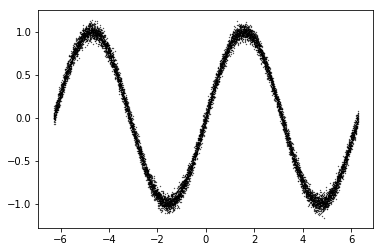

In [16]:
# generate the data
inputs = np.linspace(-2*np.pi, 2*np.pi, 10000)[:, None]
outputs = np.sin(inputs) + 0.05 * np.random.normal(size=[len(inputs),1])

plt.scatter(inputs[:, 0], outputs[:, 0], s=0.1, color='k', marker='o')

In [21]:
sess = tf_reset_default()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[1,3], initializer=tf.contrib.layers.xavier_initializer())
    #W1 = tf.get_variable(name='W1', shape=[20, 20], initializer=tf.contrib.layers.xavier_initializer())
    #W2 = tf.get_variable(name='W2', shape=[20, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    #b1 = tf.get_variable(name='b1', shape=[20], initializer=tf.constant_initializer(0.))
    #b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))

    weights = [W0]#[W0, W1, W2]
    biases = [b0]#[b0, b1, b2]
    activations = [tf.nn.relu]#[tf.nn.sigmoid, tf.nn.relu, tf.nn.sigmoid]

    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
    output_pred = layer
    
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred = create_model()
    
# create loss
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(10000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, '/tmp/model.ckpt')

0000 mse: 2.115
1000 mse: 0.230
2000 mse: 0.238
3000 mse: 0.231
4000 mse: 0.214
5000 mse: 0.140
6000 mse: 0.197
7000 mse: 0.231
8000 mse: 0.210
9000 mse: 0.245


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


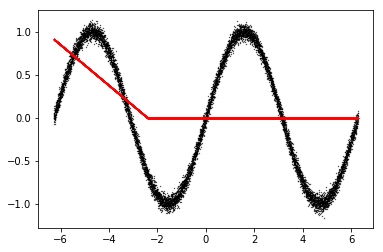

In [22]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

plt.scatter(inputs[:, 0], outputs[:, 0], c='k', marker='o', s=0.1)
plt.scatter(inputs[:, 0], output_pred_run[:, 0], c='r', marker='o', s=0.1)

In [32]:
n = 10000
X = np.random.uniform(0,1,(n,2))
p = 1 / (1 + np.exp(-5*(X.sum(axis=1) - 2.* (X[:,0] * X[:,1] > .25) - .5)))
y = np.random.uniform(0,1,n) < p

In [33]:
import plotnine as p9
import pandas as pd

In [34]:
XOR_data = pd.DataFrame(X,columns=['X0','X1'])
XOR_data['p'] = p

In [59]:
XOR_data.head()
inputs = np.array(XOR_data.iloc[:,0:2]).astype('float32')
outputs = np.array(XOR_data.iloc[:,2]).reshape((inputs.shape[0],1))
print(inputdata.shape,outputs.shape)

(10000, 2) (10000, 1)


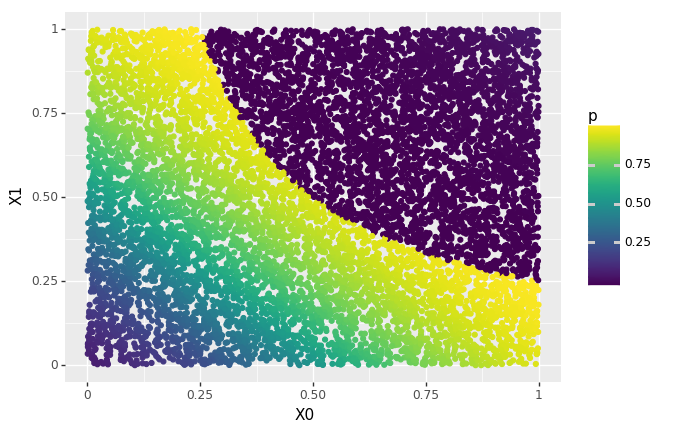

<ggplot: (-9223371947463327495)>

In [42]:
p9.ggplot(XOR_data,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

__Exercise 2.__ (15 pts) Create a neural net with dense hidden layers (including intercepts for each hidden unit) and logistic loss function.  Train it on the above dataset with 2 dimensional input using Adam and 32 minibatch size.  You may want to increase the number of iterations until you see convergence.  You can assess visually by plotting the predictions and comparing to the true probability.

1. Try ReLu activation as well as sigmoid activation for 1 hidden layer and 3 units.
2. Try ReLu activation with 2 hidden layers and 3 units each.
3. Try (2) but with any combination of ReLu and Sigmoid activation.

In [83]:
#1. Relu
sess = tf_reset_default()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None,1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[2,3], initializer=tf.contrib.layers.xavier_initializer())
    #W1 = tf.get_variable(name='W1', shape=[20, 20], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    #b1 = tf.get_variable(name='b1', shape=[20], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[1], initializer=tf.constant_initializer(0.))

    weights = [W0,W1]#[W0, W1, W2]
    biases = [b0,b1]#[b0, b1, b2]
    activations = [tf.nn.relu,tf.nn.sigmoid]#[tf.nn.sigmoid, tf.nn.relu, tf.nn.sigmoid]

    # create computation graph
    layer = input_ph
    print('input shape = ',input_ph.get_shape())
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
    output_pred = layer
    print(output_ph, output_pred)
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred = create_model()
    
# create loss
#product = tf.multiply(output_ph,output_pred)
#logloss = tf.reduce_sum(-tf.log(1 + tf.exp(-(product))))
#logloss = -tf.reduce_sum((tf.multiply(output_ph,tf.log(output_pred)) + tf.multiply((1 - output_ph),tf.log(1 - output_pred))))
logloss = tf.losses.log_loss(output_ph,output_pred)

# create optimizer
opt = tf.train.AdamOptimizer().minimize(logloss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(50000):
    #print('in the training')
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the mse
    _, logloss_run = sess.run([opt, logloss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} logloss: {1:.3f}'.format(training_step, logloss_run))
        saver.save(sess, '/tmp/model.ckpt')

input shape =  (?, 2)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("Sigmoid:0", shape=(?, 1), dtype=float32)
0000 logloss: 0.725
1000 logloss: 0.600
2000 logloss: 0.641
3000 logloss: 0.530
4000 logloss: 0.576
5000 logloss: 0.495
6000 logloss: 0.416
7000 logloss: 0.357
8000 logloss: 0.509
9000 logloss: 0.486
10000 logloss: 0.364
11000 logloss: 0.457
12000 logloss: 0.413
13000 logloss: 0.502
14000 logloss: 0.364
15000 logloss: 0.461
16000 logloss: 0.546
17000 logloss: 0.447
18000 logloss: 0.385
19000 logloss: 0.383
20000 logloss: 0.403
21000 logloss: 0.353
22000 logloss: 0.355
23000 logloss: 0.434
24000 logloss: 0.470
25000 logloss: 0.381
26000 logloss: 0.381
27000 logloss: 0.377
28000 logloss: 0.435
29000 logloss: 0.525
30000 logloss: 0.538
31000 logloss: 0.500
32000 logloss: 0.482
33000 logloss: 0.355
34000 logloss: 0.403
35000 logloss: 0.463
36000 logloss: 0.412
37000 logloss: 0.406
38000 logloss: 0.334
39000 logloss: 0.464
40000 logloss: 0.420
41000 logloss: 0.404
42

input shape =  (?, 2)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("Sigmoid:0", shape=(?, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


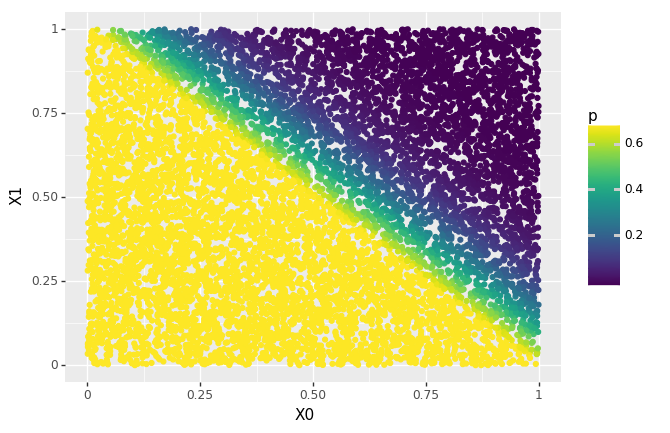

<ggplot: (-9223371947452406952)>

In [82]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

XOR_data_copy = XOR_data.copy()
XOR_data_copy.iloc[:,2] = output_pred_run
p9.ggplot(XOR_data_copy,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

In [84]:
#1. Sigmoid
sess = tf_reset_default()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None,1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[2,3], initializer=tf.contrib.layers.xavier_initializer())
    #W1 = tf.get_variable(name='W1', shape=[20, 20], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    #b1 = tf.get_variable(name='b1', shape=[20], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[1], initializer=tf.constant_initializer(0.))

    weights = [W0,W1]#[W0, W1, W2]
    biases = [b0,b1]#[b0, b1, b2]
    activations = [tf.nn.sigmoid,tf.nn.sigmoid]#[tf.nn.sigmoid, tf.nn.relu, tf.nn.sigmoid]

    # create computation graph
    layer = input_ph
    print('input shape = ',input_ph.get_shape())
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
    output_pred = layer
    print(output_ph, output_pred)
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred = create_model()
    
# create loss
#product = tf.multiply(output_ph,output_pred)
#logloss = tf.reduce_sum(-tf.log(1 + tf.exp(-(product))))
#logloss = -tf.reduce_sum((tf.multiply(output_ph,tf.log(output_pred)) + tf.multiply((1 - output_ph),tf.log(1 - output_pred))))
logloss = tf.losses.log_loss(output_ph,output_pred)

# create optimizer
opt = tf.train.AdamOptimizer().minimize(logloss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(50000):
    #print('in the training')
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the mse
    _, logloss_run = sess.run([opt, logloss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} logloss: {1:.3f}'.format(training_step, logloss_run))
        saver.save(sess, '/tmp/model.ckpt')

input shape =  (?, 2)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("Sigmoid_1:0", shape=(?, 1), dtype=float32)
0000 logloss: 0.748
1000 logloss: 0.646
2000 logloss: 0.683
3000 logloss: 0.623
4000 logloss: 0.587
5000 logloss: 0.578
6000 logloss: 0.624
7000 logloss: 0.605
8000 logloss: 0.598
9000 logloss: 0.590
10000 logloss: 0.542
11000 logloss: 0.597
12000 logloss: 0.601
13000 logloss: 0.524
14000 logloss: 0.568
15000 logloss: 0.546
16000 logloss: 0.481
17000 logloss: 0.521
18000 logloss: 0.521
19000 logloss: 0.518
20000 logloss: 0.539
21000 logloss: 0.400
22000 logloss: 0.521
23000 logloss: 0.446
24000 logloss: 0.473
25000 logloss: 0.442
26000 logloss: 0.454
27000 logloss: 0.457
28000 logloss: 0.499
29000 logloss: 0.420
30000 logloss: 0.413
31000 logloss: 0.490
32000 logloss: 0.429
33000 logloss: 0.483
34000 logloss: 0.410
35000 logloss: 0.447
36000 logloss: 0.359
37000 logloss: 0.365
38000 logloss: 0.318
39000 logloss: 0.339
40000 logloss: 0.357
41000 logloss: 0.428


input shape =  (?, 2)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("Sigmoid_1:0", shape=(?, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


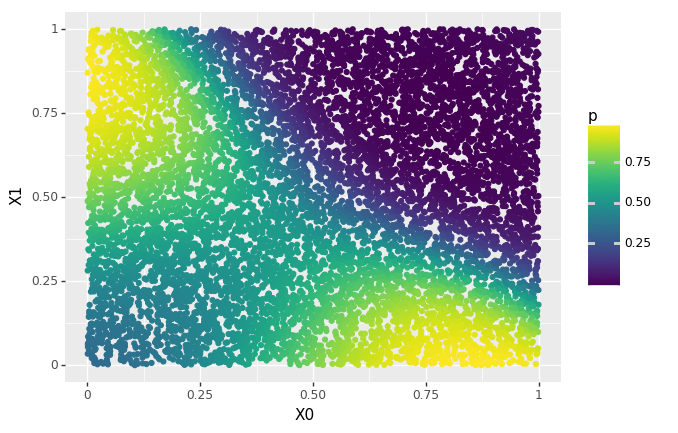

<ggplot: (-9223371947451215100)>

In [85]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

XOR_data_copy = XOR_data.copy()
XOR_data_copy.iloc[:,2] = output_pred_run
p9.ggplot(XOR_data_copy,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

In [86]:
#2. Relu
sess = tf_reset_default()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None,1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[2,3], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 3], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[3], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))

    weights = [W0,W1,W2]#[W0, W1, W2]
    biases = [b0,b1,b2]#[b0, b1, b2]
    activations = [tf.nn.relu,tf.nn.relu,tf.nn.sigmoid]#[tf.nn.sigmoid, tf.nn.relu, tf.nn.sigmoid]

    # create computation graph
    layer = input_ph
    print('input shape = ',input_ph.get_shape())
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
    output_pred = layer
    print(output_ph, output_pred)
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred = create_model()
    
# create loss
#product = tf.multiply(output_ph,output_pred)
#logloss = tf.reduce_sum(-tf.log(1 + tf.exp(-(product))))
#logloss = -tf.reduce_sum((tf.multiply(output_ph,tf.log(output_pred)) + tf.multiply((1 - output_ph),tf.log(1 - output_pred))))
logloss = tf.losses.log_loss(output_ph,output_pred)

# create optimizer
opt = tf.train.AdamOptimizer().minimize(logloss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(50000):
    #print('in the training')
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the mse
    _, logloss_run = sess.run([opt, logloss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} logloss: {1:.3f}'.format(training_step, logloss_run))
        saver.save(sess, '/tmp/model.ckpt')

input shape =  (?, 2)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("Sigmoid:0", shape=(?, 1), dtype=float32)
0000 logloss: 0.696
1000 logloss: 0.461
2000 logloss: 0.439
3000 logloss: 0.417
4000 logloss: 0.302
5000 logloss: 0.351
6000 logloss: 0.419
7000 logloss: 0.373
8000 logloss: 0.324
9000 logloss: 0.324
10000 logloss: 0.306
11000 logloss: 0.316
12000 logloss: 0.287
13000 logloss: 0.335
14000 logloss: 0.311
15000 logloss: 0.344
16000 logloss: 0.341
17000 logloss: 0.370
18000 logloss: 0.376
19000 logloss: 0.336
20000 logloss: 0.320
21000 logloss: 0.352
22000 logloss: 0.310
23000 logloss: 0.352
24000 logloss: 0.347
25000 logloss: 0.335
26000 logloss: 0.318
27000 logloss: 0.303
28000 logloss: 0.270
29000 logloss: 0.351
30000 logloss: 0.293
31000 logloss: 0.305
32000 logloss: 0.304
33000 logloss: 0.352
34000 logloss: 0.318
35000 logloss: 0.362
36000 logloss: 0.356
37000 logloss: 0.269
38000 logloss: 0.338
39000 logloss: 0.383
40000 logloss: 0.395
41000 logloss: 0.271
42

input shape =  (?, 2)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("Sigmoid:0", shape=(?, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


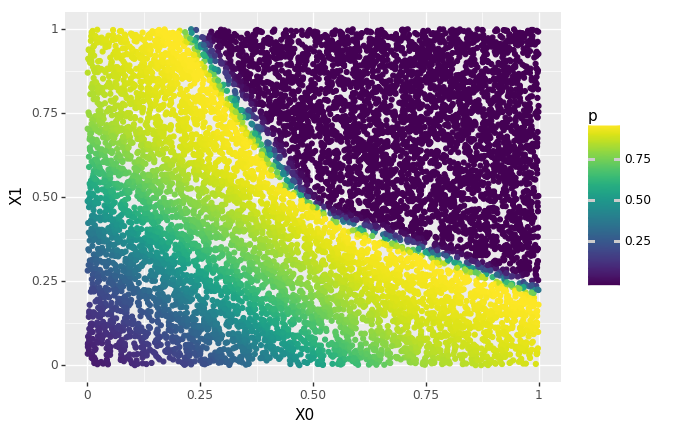

<ggplot: (89402592008)>

In [87]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

XOR_data_copy = XOR_data.copy()
XOR_data_copy.iloc[:,2] = output_pred_run
p9.ggplot(XOR_data_copy,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

In [88]:
#3. Relu,Sigmoid
sess = tf_reset_default()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None,1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[2,3], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 3], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[3], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))

    weights = [W0,W1,W2]#[W0, W1, W2]
    biases = [b0,b1,b2]#[b0, b1, b2]
    activations = [tf.nn.relu,tf.nn.sigmoid,tf.nn.sigmoid]#[tf.nn.sigmoid, tf.nn.relu, tf.nn.sigmoid]

    # create computation graph
    layer = input_ph
    print('input shape = ',input_ph.get_shape())
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
    output_pred = layer
    print(output_ph, output_pred)
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred = create_model()
    
# create loss
#product = tf.multiply(output_ph,output_pred)
#logloss = tf.reduce_sum(-tf.log(1 + tf.exp(-(product))))
#logloss = -tf.reduce_sum((tf.multiply(output_ph,tf.log(output_pred)) + tf.multiply((1 - output_ph),tf.log(1 - output_pred))))
logloss = tf.losses.log_loss(output_ph,output_pred)

# create optimizer
opt = tf.train.AdamOptimizer().minimize(logloss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(50000):
    #print('in the training')
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the mse
    _, logloss_run = sess.run([opt, logloss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} logloss: {1:.3f}'.format(training_step, logloss_run))
        saver.save(sess, '/tmp/model.ckpt')

input shape =  (?, 2)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("Sigmoid_1:0", shape=(?, 1), dtype=float32)
0000 logloss: 0.763
1000 logloss: 0.696
2000 logloss: 0.613
3000 logloss: 0.501
4000 logloss: 0.482
5000 logloss: 0.490
6000 logloss: 0.464
7000 logloss: 0.324
8000 logloss: 0.353
9000 logloss: 0.330
10000 logloss: 0.448
11000 logloss: 0.293
12000 logloss: 0.419
13000 logloss: 0.293
14000 logloss: 0.292
15000 logloss: 0.395
16000 logloss: 0.295
17000 logloss: 0.348
18000 logloss: 0.337
19000 logloss: 0.387
20000 logloss: 0.286
21000 logloss: 0.277
22000 logloss: 0.290
23000 logloss: 0.412
24000 logloss: 0.337
25000 logloss: 0.373
26000 logloss: 0.394
27000 logloss: 0.388
28000 logloss: 0.358
29000 logloss: 0.346
30000 logloss: 0.349
31000 logloss: 0.302
32000 logloss: 0.283
33000 logloss: 0.361
34000 logloss: 0.378
35000 logloss: 0.291
36000 logloss: 0.332
37000 logloss: 0.309
38000 logloss: 0.361
39000 logloss: 0.406
40000 logloss: 0.359
41000 logloss: 0.216


input shape =  (?, 2)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("Sigmoid_1:0", shape=(?, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


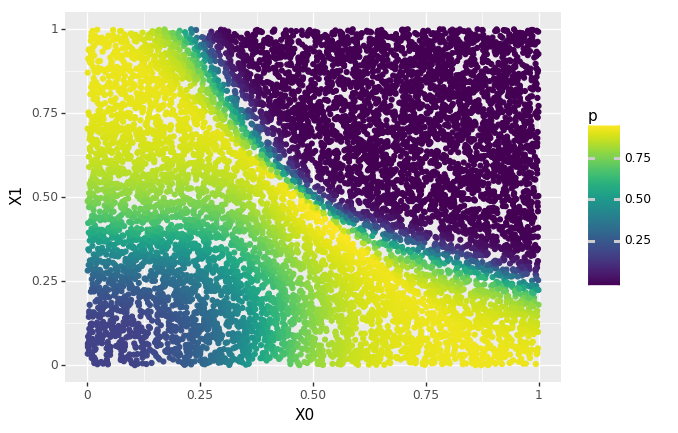

<ggplot: (-9223371947446081876)>

In [89]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

XOR_data_copy = XOR_data.copy()
XOR_data_copy.iloc[:,2] = output_pred_run
p9.ggplot(XOR_data_copy,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()